In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy 
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
import copy

In [2]:
#Loading the data (cat/non-cat)
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

y = 0. It's a non-cat picture.


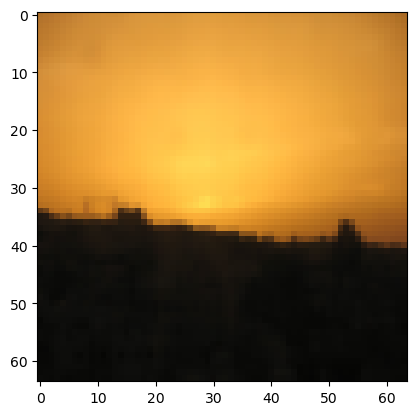

In [4]:
#Example of a picture
index = 80
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [5]:
#Explore the dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [6]:
#Reshape the training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

#Standardize data to have feature values between 0 and 1
train_x = train_x_flatten/255
test_x = test_x_flatten/255

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


**L-layer Neural Network**

In [7]:
#Initialize parameters for L-layer neural network
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [8]:
# L-model forward
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

In [9]:
def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == "sigmoid":
        A = 1/(1 + np.exp(-Z))
        activation_cache = Z
    elif activation == "relu":
        A = np.maximum(0,Z)
        activation_cache = Z  
    
    cache = (linear_cache, activation_cache)

    return A, cache

In [10]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
    caches.append(cache)
    
    return AL, caches

In [11]:
#Compute the cost Function
def compute_cost(AL, Y):
    m = Y.shape[1]

    logprobs = np.multiply(np.log(AL),Y) + np.multiply(np.log(1 - AL), (1 - Y))
    cost = - 1/m * (np.sum(logprobs))

    cost = np.squeeze(cost)
    
    return cost

In [12]:
#L-model backward
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [13]:
def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0

    return dZ

def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    s = 1/(1 + np.exp(-Z))
    dZ = dA * s * (1 - s)

    return dZ

In [14]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


In [15]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [16]:
# Update Parameters
def update_parameters(parameters, grads, learning_rate):

    parameters = copy.deepcopy(parameters)
    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] -=  learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -=  learning_rate * grads["db" + str(l+1)]

    return parameters